# BO on 2D Mesh Surface 



## Importing everything

In [1]:
%pip install -e "../Altered packages/GeometricKernels" pymanopt matplotlib ipympl kaleido plotly scipy

import copy
import random
from pathlib import Path

import geometric_kernels
import kaleido
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objects as go
import plotly.io as pio
from geometric_kernels.kernels import MaternGeometricKernel
from geometric_kernels.spaces import Mesh, Hypersphere
from plotly.subplots import make_subplots
from Plotting import *
from scipy.stats import norm

pio.renderers.default = "browser"

Obtaining file:///workspaces/Newest-try-/Altered%20packages/GeometricKernels
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for geometric_kernels (pyproject.toml) ... done
  Created wheel for geometric_kernels: filename=geometric_kernels-0.4-py3-none-any.whl size=8835 sha256=84623443072de2c554826b98dc0c7530ef53b187429818cdb5c3ace0f4c02adc
  Stored in directory: /tmp/pip-ephem-wheel-cache-tpg7awby/wheels/a3/88/0f/62cc36c2f8a5adcb8e307bac8051fd1078533735e772aadd33
Successfully built geometric_kernels
  Attempting uninstall: geometric_kernels
    Found existing installation: geometric_kernels 0.4
    Uninstalling geometric_kernels-0.4:
      Successfully uninstalled geometric_kernels-0.4


INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.


Note: you may need to restart the kernel to use updated packages.


/usr/local/python/3.12.1/lib/python3.12/site-packages/spherical_harmonics/fundamental_set.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


## Mesh and kernel setup

In [2]:
MeshFolder_dir = Path.cwd()
Filename = "100 POINTS ONE.obj"
mesh = Mesh.load_mesh(str(MeshFolder_dir / Filename))
print("DIR:", MeshFolder_dir)
print("num_vertices:", mesh.num_vertices)

kernel = MaternGeometricKernel(mesh)

LENGTH_SCALE, NU = 4, 0.5
VARIANCE = "NEEDS_CONFIGURING"  # variance not yet exposed in the package

params = kernel.init_params()
params["lengthscale"] = np.array([LENGTH_SCALE])
params["nu"] = np.array([NU])


DIR: /workspaces/Newest-try-/3D demo (Poisson surface reconstruction + BO)
num_vertices: 3990


## Objective function

In [3]:
def f(x):
    """Simple objective: return the first coordinate of the node (1-indexed input)."""
    idx = np.asarray(x, dtype=np.int64).flatten()
    coords = mesh.vertices[idx - 1]
    return coords[..., 0]

j = np.vectorize(f)


## BO setup

In [4]:
def expected_improvement(mu, sigma, f_best, xi=0.9):
    """
    Expected Improvement acquisition function.

    Args:
        mu: posterior mean
        sigma: posterior std dev
        f_best: best observed value
        xi: exploration-exploitation trade-off

    Returns:
        EI values for all points
    """
    with np.errstate(divide='ignore'):
        mu = mu.reshape(-1, 1)
        sigma = sigma.reshape(-1, 1)
        Z = (f_best - mu - xi) / sigma

    ei = (f_best - mu - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei = np.where(sigma > 1e-10, ei, 0.0)
    return ei


def BO_loop_fixed(num_iterations, x_obs=None, objective_func=None):
    """
    Bayesian optimization loop with geometric kernel.

    Args:
        num_iterations: number of BO steps
        x_obs: initial observed points
        objective_func: function to optimize

    Returns:
        posterior mean, std dev, EI, observations, and values
    """
    if objective_func is None:
        objective_func = f
    if x_obs is None:
        raise ValueError("x_obs must be provided")

    num_verts = mesh.num_vertices
    whole_domain = np.atleast_2d(np.arange(1, num_verts + 1)).T

    y_observed = np.atleast_2d(np.apply_along_axis(objective_func, 1, x_obs)).reshape(-1, 1)
    K_XX_prior = kernel.K(params, whole_domain - 1, whole_domain - 1)
    mu_prior_vector = np.zeros((num_verts, 1))

    for i in range(num_iterations):
        m_vector = mu_prior_vector[x_obs.flatten() - 1]
        K_xX = kernel.K(params, x_obs - 1, whole_domain - 1)
        K_xx = kernel.K(params, x_obs - 1, x_obs - 1)
        K_Xx = K_xX.T

        K_xx_stable = K_xx + np.eye(K_xx.shape[0]) * 1e-6
        C_inv = np.linalg.pinv(K_xx_stable)

        mew_vec = mu_prior_vector + K_Xx @ C_inv @ (y_observed - m_vector)
        Current_K_matrix = K_XX_prior - K_Xx @ C_inv @ K_xX
        Sigma_vec = np.diag(Current_K_matrix).copy().reshape(-1, 1)
        Sigma_vec[Sigma_vec < 0] = 0

        EI_vec = expected_improvement(mew_vec, np.sqrt(Sigma_vec), np.min(y_observed))

        next_point = np.argmax(EI_vec) + 1
        next_point = np.atleast_2d(next_point)

        y_next = np.atleast_2d(objective_func(np.array([next_point.item()]))).reshape(-1, 1)
        x_obs = np.vstack((x_obs, next_point))
        y_observed = np.vstack((y_observed, y_next))

    return mew_vec, Sigma_vec, EI_vec, x_obs, y_observed

## Run BO

In [5]:
objective_vals = j(np.arange(1, mesh.num_vertices + 1))

# === CUSTOM PLOTTING FUNCTION ===
objective_plot_kwargs = dict(
    name="objective value",
    marker=dict(size=10, colorscale="hot"),
)
objective_trace = vector_values_to_mesh_trace(mesh, objective_vals, **objective_plot_kwargs)
hover_kwargs = dict(
    customdata=np.hstack(
        [np.atleast_2d(objective_vals).T, np.atleast_2d(np.arange(1, mesh.num_vertices + 1)).T]
    ),
    hovertemplate=(
        "x : %{x:.2f}<br>"
        + "y : %{y:.2f}<br>"
        + "z : %{z:.2f}<br>"
        + "objective value: %{customdata[0]:.2f}<br>"
        + "node index: %{customdata[1]}"
    ),
)
# === END CUSTOM ===
objective_trace = add_custom_hover_data(objective_trace, **hover_kwargs)

initial_point = np.array([[np.random.randint(1, mesh.num_vertices)]])
mu_1, sigma_1, ei_1, X_1, Y_1 = BO_loop_fixed(1, x_obs=initial_point, objective_func=f)
mu_2, sigma_2, ei_2, X_2, Y_2 = BO_loop_fixed(2, x_obs=initial_point, objective_func=f)
mu_3, sigma_3, ei_3, X_3, Y_3 = BO_loop_fixed(3, x_obs=initial_point, objective_func=f)
mu_4, sigma_4, ei_4, X_4, Y_4 = BO_loop_fixed(4, x_obs=initial_point, objective_func=f)
mu_5, sigma_5, ei_5, X_5, Y_5 = BO_loop_fixed(5, x_obs=initial_point, objective_func=f)
mu_6, sigma_6, ei_6, X_6, Y_6 = BO_loop_fixed(6, x_obs=initial_point, objective_func=f)

advanced_fig = go.Figure()

mu_1_trace = vector_values_to_mesh_trace(mesh, mu_1)
mu_2_trace = vector_values_to_mesh_trace(mesh, mu_2)
mu_3_trace = vector_values_to_mesh_trace(mesh, mu_3)
mu_4_trace = vector_values_to_mesh_trace(mesh, mu_4)
mu_5_trace = vector_values_to_mesh_trace(mesh, mu_5)
mu_6_trace = vector_values_to_mesh_trace(mesh, mu_6)

# === CUSTOM PLOTTING ===
mu_1_trace = add_custom_hover_data(mu_1_trace, customdata=mu_1)
mu_1_trace.name = "After 1 sample point"
mu_2_trace = add_custom_hover_data(mu_2_trace, customdata=mu_2)
mu_2_trace.name = "After 2 sample points"
mu_3_trace = add_custom_hover_data(mu_3_trace, customdata=mu_3)
mu_3_trace.name = "After 3 sample points"
mu_4_trace = add_custom_hover_data(mu_4_trace, customdata=mu_4)
mu_4_trace.name = "After 4 sample points"
mu_5_trace = add_custom_hover_data(mu_5_trace, customdata=mu_5)
mu_5_trace.name = "After 5 sample points"
mu_6_trace = add_custom_hover_data(mu_6_trace, customdata=mu_6)
mu_6_trace.name = "After 6 sample points"
# === END CUSTOM ===

advanced_fig.add_trace(mu_1_trace)
advanced_fig.add_trace(mu_2_trace)
advanced_fig.add_trace(mu_3_trace)
advanced_fig.add_trace(mu_4_trace)
advanced_fig.add_trace(mu_5_trace)
advanced_fig.add_trace(mu_6_trace)
advanced_fig.add_trace(objective_trace)

# Add explored points (projected to first 3D for visualization)
proj_points_6 = mesh.vertices[np.int64(X_6.flatten() - 1)][:, :3]

# === CUSTOM DISPLAY ===
fig_show(advanced_fig)
# === END CUSTOM ===

print(
    "Sampled values (sorted for 6 samples):", sorted(list(Y_6)),
    "\nTrue minimum:", np.min(objective_vals),
    "at index:", np.argmax(-1 * objective_vals),
)
print("Initial point value:", objective_vals[initial_point.squeeze() - 1])


Sampled values (sorted for 6 samples): [array([-0.98348969]), array([-0.92408365]), array([-0.91744316]), array([-0.40308923]), array([-0.19937873]), array([-0.13147527]), array([0.14013875])] 
True minimum: -1.05024886 at index: 448
Initial point value: -0.13147527


In [6]:
path_points = mesh.vertices[np.int64(X_3.flatten() - 1)][:, :3]
path_labels = [f"POINT {i+1}" for i in range(path_points.shape[0])]

# Uniform bright blue for all sampled points
point_color = "#008CFF"

path_fig = copy.deepcopy(advanced_fig)

# Line to connect the sampled points in order
path_line = go.Scatter3d(
    x=path_points[:, 0],
    y=path_points[:, 1],
    z=path_points[:, 2],
    mode="lines",
    line=dict(color=point_color, width=4),
    name="Sample path",
    hovertemplate="PATH<extra></extra>",
    showlegend=True,
)
path_fig.add_trace(path_line)

# Individual traces per sampled point with hover text "POINT N"
for i, (coord, label) in enumerate(zip(path_points, path_labels)):
    path_fig.add_trace(
        go.Scatter3d(
            x=[coord[0]],
            y=[coord[1]],
            z=[coord[2]],
            mode="markers",
            marker=dict(color=point_color, size=14, symbol="circle"),
            name=label,
            hovertemplate=f"{label}<extra></extra>",
            showlegend=True,
        )
    )

# Show updated figure with path overlays
fig_show(path_fig)


In [7]:
# # BO convergence plot with traces for 1-6 sample points
# iterations = list(range(1, 7))  # 1 to 6 sample points
# true_min = np.min(objective_vals)

# # Generate BO results for 1-6 sample points
# best_found_values = []
# suboptimality_gaps = []

# for num_samples in iterations:
#     mu, sigma, ei, X, Y = BO_loop_fixed(num_samples, x_obs=initial_point, objective_func=f)
#     best_found = np.min(Y)
#     best_found_values.append(best_found)
#     suboptimality_gaps.append(best_found - true_min)

# plt.figure(figsize=(10, 6))
# plt.plot(iterations, suboptimality_gaps, 'o-', color='blue', markersize=12, linewidth=2.5, label='Suboptimality Gap')
# plt.title(f'BO Performance: Suboptimality Gap vs. Number of Sample Points\n(True min: {true_min:.4f})', fontsize=13, fontweight='bold')
# plt.xlabel('Number of Sample Points Taken', fontsize=11)
# plt.ylabel('Gap from Best (Best Found - True Min)', fontsize=11)
# plt.xticks(iterations)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend(loc='upper right', fontsize=11)
# plt.tight_layout()
# plt.show()

# # Print summary
# print("Summary of BO Performance:")
# print("Sample Points | Best Value Found | Suboptimality Gap")
# print("-" * 55)
# for num_samples, best_val, gap in zip(iterations, best_found_values, suboptimality_gaps):
#     print(f"      {num_samples:2d}       |      {best_val:10.6f}      |     {gap:10.6f}")


## Kernel influence visualisation

In [8]:
def visualize_kernel_influence(mesh, kernel, params, source_point):
    """
    Visualize kernel influence from a source point across the mesh.

    Args:
        mesh: the 3D mesh
        kernel: geometric kernel
        params: kernel parameters
        source_point: index of source point

    Returns:
        Plotly figure
    """
    source_idx = np.atleast_2d([source_point])
    all_points = np.atleast_2d(np.arange(mesh.num_vertices)).T
    K_influence = kernel.K(params, source_idx, all_points).flatten()

    fig = go.Figure()

    # === CUSTOM MESH VISUALIZATION ===
    influence_trace = vector_values_to_mesh_trace(
        mesh,
        K_influence,
        marker=dict(colorscale="Viridis", colorbar=dict(title="Kernel Value")),
    )
    influence_trace = add_custom_hover_data(influence_trace, customdata=K_influence.reshape(-1, 1))
    # === END CUSTOM ===
    fig.add_trace(influence_trace)

    source_coord = mesh.vertices[source_point][:3]  # project to 3D
    j_trace = go.Scatter3d(
        x=[source_coord[0]],
        y=[source_coord[1]],
        z=[source_coord[2]],
        mode="markers",
        marker=dict(size=15, color="red", symbol="diamond"),
        name="Source Point",
    )

    # === CUSTOM HOVER ===
    j_trace = add_custom_hover_data(j_trace, customdata=K_influence.reshape(-1, 1))
    # === END CUSTOM ===
    fig.add_trace(j_trace)

    fig.update_layout(title=f"Kernel Influence from Point {source_point}")
    return fig

initial_point = np.array([[4]]) - 1
influence_fig = visualize_kernel_influence(mesh, kernel, params, initial_point.item())
# === CUSTOM DISPLAY ===
fig_show(influence_fig)
# === END CUSTOM ===


## Geodesic vs. mesh kernel comparison

In [9]:
poisson_mesh_points = mesh.vertices
original_mesh_points = np.empty((0, 3), dtype=np.float32)


In [10]:
# Load original point cloud from PLY
with open("100 POINTS ONE.ply", "rb") as file:
    vectors_start = False
    for line in file:
        try:
            line_str = line.decode('utf-8', errors='ignore').strip()
        except:
            continue
        
        if line_str == 'end_header':
            vectors_start = True
            continue
        elif vectors_start:
            try:
                line_arr = list(map(float, line_str.split()[:3]))
                new_vec = np.array(line_arr).reshape(1, -1)
                original_mesh_points = np.vstack((original_mesh_points, new_vec))
            except:
                continue

In [11]:
def find_nearest_poisson(original_point):
    """Find nearest poisson vertex to original point."""
    min_dist = 10000
    best_one = 0
    for node_ind in range(mesh.num_vertices):
        poisson_point = mesh.vertices[node_ind]
        poisson_point = poisson_point / np.linalg.norm(poisson_point, keepdims=True)
        if np.linalg.norm(poisson_point - original_point) < min_dist:
            min_dist = np.linalg.norm(poisson_point - original_point)
            best_one = node_ind
    return best_one

# Map original points to nearest poisson vertices
INDS_VECTOR = np.zeros((original_mesh_points.shape[0], 1))
for i in range(original_mesh_points.shape[0]):
    point_1 = original_mesh_points[i, :]
    INDS_VECTOR[i] = find_nearest_poisson(point_1)

BASTARD_KERNEL_MATRIX = kernel.K(params, INDS_VECTOR, INDS_VECTOR)


In [12]:
# Compute continuous kernel on S^2 (2-sphere in 3D)
proper_cts_sphere = Hypersphere(dim=2)
cts_kernel = MaternGeometricKernel(proper_cts_sphere)

Dist_matrix = np.zeros((original_mesh_points.shape[0], original_mesh_points.shape[0]))
original_mesh_points = original_mesh_points / np.linalg.norm(
    original_mesh_points, axis=1, keepdims=True
)
CTS_kernel_matrix = cts_kernel.K(params, original_mesh_points, original_mesh_points)

# Compute geodesic distances
for i in range(original_mesh_points.shape[0]):
    for j in range(i, original_mesh_points.shape[0]):
        point_1 = original_mesh_points[i]
        point_2 = original_mesh_points[j]
        dot_product = np.dot(point_1, point_2)
        clipped_dot_product = np.clip(dot_product, -1.0, 1.0)
        geodesic_dist = np.arccos(clipped_dot_product)
        Dist_matrix[j][i] = geodesic_dist
        Dist_matrix[i][j] = geodesic_dist


## Compare kernels

In [13]:
# Flatten matrices for plotting
c = Dist_matrix.flatten()  # geodesic distances
b = CTS_kernel_matrix.flatten()  # continuous kernel
a = BASTARD_KERNEL_MATRIX.flatten()  # mesh kernel


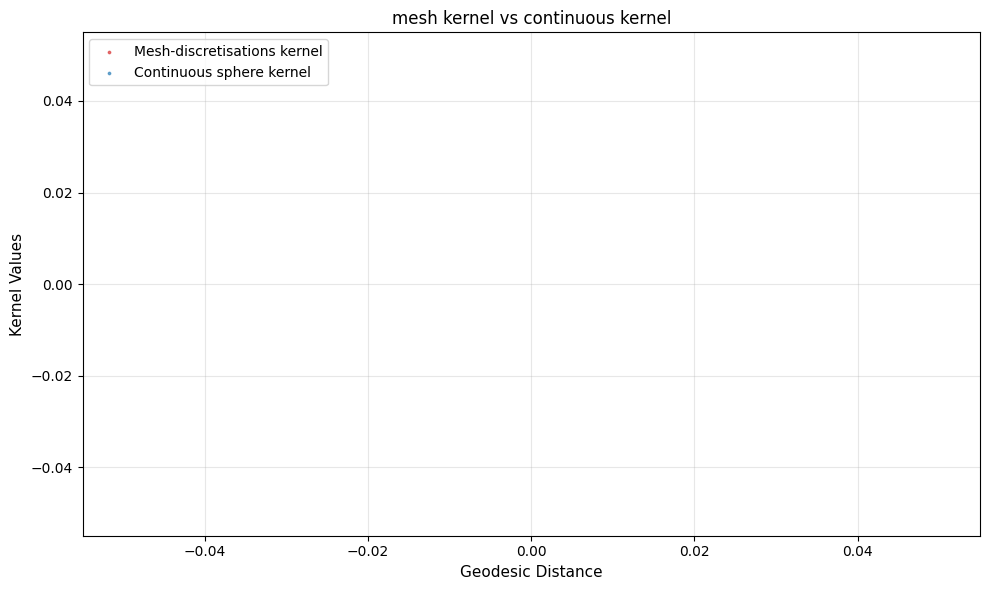

In [14]:
# Scatter plot: mesh kernel vs continuous kernel as function of geodesic distance
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Geodesic Distance', fontsize=11)
ax.set_ylabel('Kernel Values', fontsize=11)
ax.scatter(c, a, c='tab:red', label='Mesh-discretisations kernel', s=3, alpha=0.6)
ax.scatter(c, b, c='tab:blue', label='Continuous sphere kernel', s=3, alpha=0.6)
ax.set_title('mesh kernel vs continuous kernel', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
